# entry network

- a network of 20 cells receiving 5 random thalamic inputs

In [8]:
# set fileName

fileName = "eg_entry-network"

In [9]:
# set libs

import pyNN.brian2 as sim
from pyNN import space 
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# simulation setting

dt         = 1 # ms
min_delay = 1 # ms
max_delay  = 1.0 # ms
simtime    = 1000.0 # ms

sim.setup(timestep = dt, 
          min_dealy = min_delay,
          max_delay = max_delay)

0

In [11]:
# network parameters

n_pop = 20     # Number of cells
weight = 0.05  # synaptic weight (µS)

cell_params = {
    'tau_m'      : 20.0,   # (ms)
    'tau_syn_E'  : 2.0,    # (ms)
    'tau_syn_I'  : 4.0,    # (ms)
    'e_rev_E'    : 0.0,    # (mV)
    'e_rev_I'    : -70.0,  # (mV)
    'tau_refrac' : 2.0,    # (ms)
    'v_rest'     : -60.0,  # (mV)
    'v_reset'    : -70.0,  # (mV)
    'v_thresh'   : -50.0,  # (mV)
    'cm'         : 0.5}    # (nF)

# see parameters meaning in http://neuralensemble.org/docs/PyNN/standardmodels.html

In [12]:
# making the network
pops = {}
pops['cx'] = sim.Population(n_pop, # number of cells
                       sim.IF_cond_exp, # cell model
                       cell_params, # cell parameters
                       label="cells")

# record state variables

pops['cx'].record(['spikes'])
pops['cx'].record(['v', 'gsyn_exc', 'gsyn_inh'])

selected random sources [1, 6, 11, 17, 19]


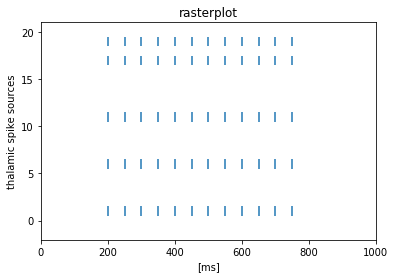

In [13]:
# designing the thalamic input

spike_times = [[]]*n_pop #list of spike lists, where one spike list is related to one spike source
random_sources_idx = [np.random.randint(0, n_pop) for i in range(5)]

for idx, sources in enumerate(random_sources_idx):
    #spike_times[sources] = [np.random.normal(loc=10, scale=0.1) for n in range(10)]
    spike_times[sources] = np.sort(np.arange(200, 800, 50).tolist())

    
pops['thalamus'] = sim.Population(n_pop, sim.SpikeSourceArray(spike_times=spike_times))
pops['thalamus'].record('spikes')

input_conns = sim.Projection(pops['thalamus'], # from 
                             pops['cx'], # to
                             connector = sim.FixedProbabilityConnector(0.5), 
                             synapse_type = sim.StaticSynapse(weight=weight, delay=min_delay),
                             receptor_type = 'excitatory')

fig, axes = plt.subplots(1,1)
axes_list = fig.axes
axes_list[0].eventplot(spike_times)
axes_list[0].set_xlabel('[ms]')
axes_list[0].set_ylabel('thalamic spike sources')
axes_list[0].set_title('rasterplot')
axes_list[0].set_xlim(0, simtime)
print('selected random sources', random_sources_idx)


In [14]:
# run simulation

sim.run(simtime) # 1000 ms


"""
a network of 20 cells receiving 5 random thalamic inputs

"""

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.04s, trying other methods took 0.25s). [brian2.stateupdaters.base.method_choice]
WARNING    Note that the synaptic pathway 'synapses_1_pre' will run on the clock of the group 'spikegeneratorgroup_1' using a dt of 100. us. Either the Synapses object 'synapses_1' or the target 'neurongroup_1' (or both) are using a different dt. This might lead to unexpected results. In particular, all delays will be rounded to multiples of 100. us. If in doubt, try to ensure that 'spikegeneratorgroup_1', 'synapses_1', and 'neurongroup_1' use the same dt. [brian2.synapses.synapses.synapses_dt_mismatch]


'\na network of 20 cells receiving 5 random thalamic inputs\n\n'

In [15]:
# save the results

outputs = {}

outputs['cx'] = pops['cx'].get_data()
for recording in ['v', 'gsyn_inh', 'gsyn_exc', 'spikes']:
    pops['cx'].write_data(fileName + '_' + str(recording) + '.pkl')

outputs['thal'] = pops['thalamus'].get_data()
for recording in ['spikes']:
    pops['thalamus'].write_data(fileName + '_' + str(recording) + '.pkl')


In [16]:
# recover results function

def recover_results(outputs):
    results = {}
    for key in outputs.keys(): # to extract the name of the layer, e.g., Exc, Inh, Thalamus, etc  
        
        # to get voltage and conductances
        for analogsignal in outputs[key].segments[0].analogsignals:
            print(analogsignal.name)
            results[key, analogsignal.name] = analogsignal

        # to get spikes
        results[key, 'spikes'] = outputs[key].segments[0].spiketrains
    return results

In [17]:
# check results

results = recover_results(outputs)
results.keys()

v
gsyn_inh
gsyn_exc


dict_keys([('cx', 'v'), ('cx', 'gsyn_inh'), ('cx', 'gsyn_exc'), ('cx', 'spikes'), ('thal', 'spikes')])

In [18]:
# check the mean firing rate

print("CX Mean firing rate: ", pops['cx'].mean_spike_count() * 1000.0 / simtime, "Hz")

print("TH Mean firing rate: ", pops['thalamus'].mean_spike_count() * 1000.0 / simtime, "Hz")

CX Mean firing rate:  10.2 Hz
TH Mean firing rate:  3.0 Hz


(0, 1000.0)

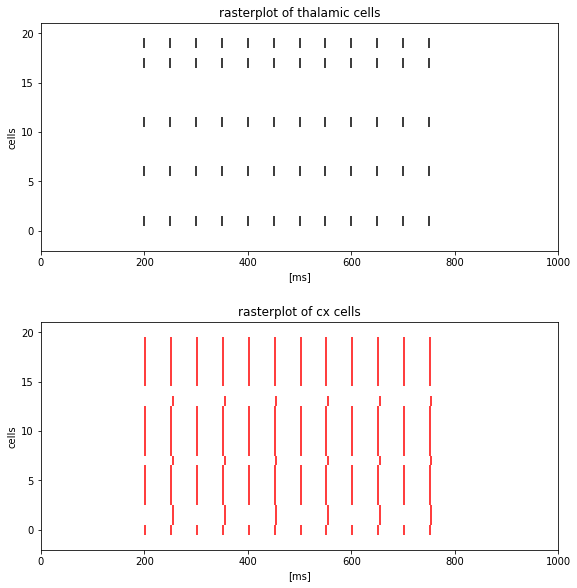

In [19]:
# check the spikes
%matplotlib inline
fig, axes = plt.subplots(2,1,figsize=(9,9))
fig.tight_layout(pad=5)
axes_list = fig.axes

axes_list[0].eventplot(results['thal', 'spikes'], color='k', label='t')
axes_list[0].set_title('rasterplot of thalamic cells')
axes_list[1].set_title('rasterplot of cx cells')
axes_list[1].eventplot(results['cx', 'spikes'], color='r', label='cx')


axes_list[0].set_xlabel('[ms]')
axes_list[0].set_ylabel('cells')
axes_list[0].set_xlim(0, simtime)

axes_list[1].set_xlabel('[ms]')
axes_list[1].set_ylabel('cells')
axes_list[1].set_xlim(0, simtime)



In [20]:
random_sources_idx

[1, 6, 11, 17, 19]

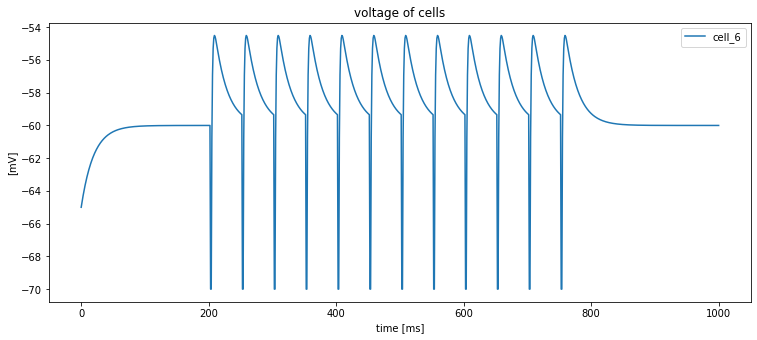

In [21]:
# check the voltage

pickedCell = random_sources_idx[1]

fig, axes = plt.subplots(1, 1, figsize=(11,5))
fig.tight_layout(pad=3)

axes_list = fig.axes
axes_list[0].plot(results['cx', 'v'].T[pickedCell], label='cell_' + str(pickedCell))

axes_list[0].set_title('voltage of cells')
axes_list[0].set_xlabel('time [ms]')
axes_list[0].set_ylabel('[mV]')
axes_list[0].legend()


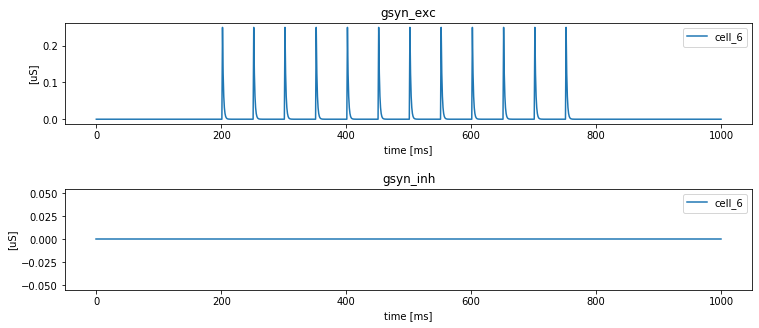

In [22]:
# check the conductance

pickedCell = random_sources_idx[1]

fig, axes = plt.subplots(2, 1, figsize=(11,5))
fig.tight_layout(pad=5)

axes_list = fig.axes

for idx, conductance in enumerate(['gsyn_exc', 'gsyn_inh']):

    fig.tight_layout(pad=3)
    axes_list = fig.axes
    axes_list[idx].plot(results['cx', conductance].T[pickedCell], label='cell_' + str(pickedCell))
    axes_list[idx].set_title(conductance)
    axes_list[idx].set_xlabel('time [ms]')
    axes_list[idx].set_ylabel('[uS]')
    axes_list[idx].legend()

## task 1: on the state variables 

- why the gsyn_inh (conductance related to cell inhibition) is equal to zero?

## task 2: on neuronal parameters

- change the tau_m (membrane time constant) parameter and have a look at the changes on the voltage trace.

- change other neuronal parameters and investigate their effect on the network behaviour

- info about parameters http://neuralensemble.org/docs/PyNN/standardmodels.html

## task 3: on neuronal model

- test another cell type looking at `sim.list_standard_models()`
